# S&DE Atelier - Visual Analytics

# Assignment 3

**Due** June 2, 2023 @23:55

**Contacts**: [marco.dambros@usi.ch](mailto:marco.dambros@usi.ch) - [carmen.armenti@usi.ch](mailto:carmen.armenti@usi.ch)

---

The goal of this assignment is to use Spark in Jupyter notebooks (PySpark). The files `trip_data.csv`, `trip_fare.csv` and `nyc_boroughs.geojson` can be found in the following folder: [Assignment3-data](https://usi365-my.sharepoint.com/:f:/g/personal/armenc_usi_ch/Ejp7sb8QAMROoWe0XUDcAkMBoqUFk-w2Vgroup025NhAww?e=TFG5CD). You should clean the data if needed. 

Note that you can use Spark [window functions](https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-window.html) whenever applicable.  

Please name your file as `SurnameName_Assignment3.ipynb`.

In [2]:
from pyspark import SparkContext, SQLContext, SparkConf
from pyspark.sql import SparkSession, Row, DataFrame, Column, GroupedData, DataFrameNaFunctions, DataFrameStatFunctions, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyarrow
import pyspark.pandas as ps
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import json
import numpy as np
import seaborn as sns
from math import *
import matplotlib.pyplot as plt
from bokeh.plotting import * 
from bokeh.models import * 
from bokeh.layouts import * 
from bokeh.models.widgets import *
from bokeh.palettes import Spectral6, Pastel1, Category20c, Inferno256, Reds256, Greens256, Blues256, Viridis256, Magma256, Plasma256, Cividis256, Category20
from bokeh.transform import *

session = SparkSession.builder.appName('Assignment_3_IC').getOrCreate()
sc = SparkContext.getOrCreate()

output_notebook()

Loading BokehJS ...

In [3]:
session

In [4]:
session.conf.set('spark.sql.repl.eagerEval.enabled', True)

### Exercise 1
Join the `trip_data` and `trip_fare` dataframes into one and consider only data on 2013-01-01.

#### Import trip_data and data cleaning

First of all, we import the 'trip_data.csv' file.

In [5]:
trip_data = session.read.option('inferSchema', True).option('header', True).csv('trip_data.csv')
trip_data

medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
89D227B655E5C82AE...,BA96DE419E711691B...,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
0BD7C8F5BA12B88E0...,9FD8F69F0804BDB55...,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.75066
0BD7C8F5BA12B88E0...,9FD8F69F0804BDB55...,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.73777,-74.009834,40.726002
DFD2202EE08F7A8DC...,51EE87E3205C985EF...,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
DFD2202EE08F7A8DC...,51EE87E3205C985EF...,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.97625,40.748528,-74.002586,40.747868
20D9ECB2CA0767CF7...,598CCE5B9C1918568...,CMT,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.7,-73.966743,40.764252,-73.983322,40.743763
496644932DF393260...,513189AD756FF14FE...,CMT,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,0.8,-73.995804,40.743977,-74.007416,40.744343
0B57B9633A2FECD3D...,CCD4367B417ED6634...,CMT,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.7,-73.989937,40.756775,-73.86525,40.77063
2C0E91FF20A856C89...,1DA2F6543A62B8ED9...,CMT,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,0.8,-73.980072,40.743137,-73.982712,40.735336
2D4B95E2FA7B2E851...,CD2F522EEE1FF5F5A...,CMT,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.5,-73.977936,40.786983,-73.952919,40.80637


We print then the schema to see the data types of each column.

In [6]:
trip_data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



Now we search for null values. Uncomment this to see the results.

In [7]:
# trip_data.filter(trip_data.medallion.isNull()).show()
# trip_data.filter(trip_data.hack_license.isNull()).show()
# trip_data.filter(trip_data.vendor_id.isNull()).show()
# trip_data.filter(trip_data.rate_code.isNull()).show()
# trip_data.filter(trip_data.store_and_fwd_flag.isNull()).show()
# trip_data.filter(trip_data.pickup_datetime.isNull()).show()
# trip_data.filter(trip_data.dropoff_datetime.isNull()).show()
# trip_data.filter(trip_data.passenger_count.isNull()).show()
# trip_data.filter(trip_data.trip_time_in_secs.isNull()).show()
# trip_data.filter(trip_data.trip_distance.isNull()).show()
# trip_data.filter(trip_data.pickup_longitude.isNull()).show()
# trip_data.filter(trip_data.pickup_latitude.isNull()).show()
# trip_data.filter(trip_data.dropoff_longitude.isNull()).show()
# trip_data.filter(trip_data.dropoff_latitude.isNull()).show()


We can see that the column 'store_and_fwd_flag' contains null values. Then, we can also see that among all these nulls there some rows that contain null values also in columns 'dropoff_datetime' and 'dropoff_longitude'. We can assume that these rows are not valid because the near columns contain all 0s and therefore we can drop them.

In [8]:
print(type(trip_data))

<class 'pyspark.sql.dataframe.DataFrame'>


Therefore, we select only the rows that do not contain null values in the column 'dropoff_longitude', and as consequence in 'dropoff_latitude'.

In [9]:
trip_data2 = trip_data.where(col('dropoff_longitude').isNotNull())
trip_data2

medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
89D227B655E5C82AE...,BA96DE419E711691B...,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
0BD7C8F5BA12B88E0...,9FD8F69F0804BDB55...,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.75066
0BD7C8F5BA12B88E0...,9FD8F69F0804BDB55...,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.73777,-74.009834,40.726002
DFD2202EE08F7A8DC...,51EE87E3205C985EF...,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
DFD2202EE08F7A8DC...,51EE87E3205C985EF...,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.97625,40.748528,-74.002586,40.747868
20D9ECB2CA0767CF7...,598CCE5B9C1918568...,CMT,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.7,-73.966743,40.764252,-73.983322,40.743763
496644932DF393260...,513189AD756FF14FE...,CMT,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,0.8,-73.995804,40.743977,-74.007416,40.744343
0B57B9633A2FECD3D...,CCD4367B417ED6634...,CMT,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.7,-73.989937,40.756775,-73.86525,40.77063
2C0E91FF20A856C89...,1DA2F6543A62B8ED9...,CMT,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,0.8,-73.980072,40.743137,-73.982712,40.735336
2D4B95E2FA7B2E851...,CD2F522EEE1FF5F5A...,CMT,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.5,-73.977936,40.786983,-73.952919,40.80637


In [10]:
trip_data2.count()

14776529

We can search for additional null values in 'dropoff_longitude' and 'dropoff_latitude' to be sure that we have dropped all the rows with null values in 'dropoff_longitude'.

Uncomment this to see the results.

In [11]:
# trip_data2.filter(trip_data2.dropoff_longitude.isNull()).show()

As there are no more null values in 'dropoff_longitude' and 'dropoff_latitude', we can go on with importing and cleaning the other dataset.

#### Import trip_fare and data cleaning

We import the 'trip_fare.csv' file.

In [12]:
trip_fare = session.read.option('inferSchema', True).option('header', True).csv('trip_fare.csv')
trip_fare

medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
89D227B655E5C82AE...,BA96DE419E711691B...,CMT,2013-01-01 15:11:48,CSH,6.5,0.0,0.5,0.0,0.0,7.0
0BD7C8F5BA12B88E0...,9FD8F69F0804BDB55...,CMT,2013-01-06 00:18:35,CSH,6.0,0.5,0.5,0.0,0.0,7.0
0BD7C8F5BA12B88E0...,9FD8F69F0804BDB55...,CMT,2013-01-05 18:49:41,CSH,5.5,1.0,0.5,0.0,0.0,7.0
DFD2202EE08F7A8DC...,51EE87E3205C985EF...,CMT,2013-01-07 23:54:15,CSH,5.0,0.5,0.5,0.0,0.0,6.0
DFD2202EE08F7A8DC...,51EE87E3205C985EF...,CMT,2013-01-07 23:25:03,CSH,9.5,0.5,0.5,0.0,0.0,10.5
20D9ECB2CA0767CF7...,598CCE5B9C1918568...,CMT,2013-01-07 15:27:48,CSH,9.5,0.0,0.5,0.0,0.0,10.0
496644932DF393260...,513189AD756FF14FE...,CMT,2013-01-08 11:01:15,CSH,6.0,0.0,0.5,0.0,0.0,6.5
0B57B9633A2FECD3D...,CCD4367B417ED6634...,CMT,2013-01-07 12:39:18,CSH,34.0,0.0,0.5,0.0,4.8,39.3
2C0E91FF20A856C89...,1DA2F6543A62B8ED9...,CMT,2013-01-07 18:15:47,CSH,5.5,1.0,0.5,0.0,0.0,7.0
2D4B95E2FA7B2E851...,CD2F522EEE1FF5F5A...,CMT,2013-01-07 15:33:28,CSH,13.0,0.0,0.5,0.0,0.0,13.5


In [13]:
trip_fare.count()

14776615

As before, we print the schema to see the data types of each column.

In [14]:
trip_fare.printSchema()

root
 |-- medallion: string (nullable = true)
 |--  hack_license: string (nullable = true)
 |--  vendor_id: string (nullable = true)
 |--  pickup_datetime: timestamp (nullable = true)
 |--  payment_type: string (nullable = true)
 |--  fare_amount: double (nullable = true)
 |--  surcharge: double (nullable = true)
 |--  mta_tax: double (nullable = true)
 |--  tip_amount: double (nullable = true)
 |--  tolls_amount: double (nullable = true)
 |--  total_amount: double (nullable = true)



We can see from the printed schema that we have a blank space before each of the column names, except for the first one. We can remove these blank spaces.

In [15]:
trip_fare = trip_fare.withColumnRenamed(' hack_license', 'hack_license') \
    .withColumnRenamed(' vendor_id', 'vendor_id') \
    .withColumnRenamed(' pickup_datetime', 'pickup_datetime') \
    .withColumnRenamed(' payment_type', 'payment_type') \
    .withColumnRenamed(' fare_amount', 'fare_amount') \
    .withColumnRenamed(' surcharge', 'surcharge') \
    .withColumnRenamed(' mta_tax', 'mta_tax') \
    .withColumnRenamed(' tip_amount', 'tip_amount') \
    .withColumnRenamed(' tolls_amount', 'tolls_amount') \
    .withColumnRenamed(' total_amount', 'total_amount')

In [16]:
trip_fare.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



By printing the schema again we are sure that there are no more blank spaces in the column names.

We check if there are null values in the dataset. Uncomment this to see the results.

In [17]:
# trip_fare.filter(trip_fare.medallion.isNull()).show()
# trip_fare.filter(trip_fare.hack_license.isNull()).show()
# trip_fare.filter(trip_fare.vendor_id.isNull()).show()
# trip_fare.filter(trip_fare.pickup_datetime.isNull()).show()
# trip_fare.filter(trip_fare.payment_type.isNull()).show()
# trip_fare.filter(trip_fare.fare_amount.isNull()).show()
# trip_fare.filter(trip_fare.surcharge.isNull()).show()
# trip_fare.filter(trip_fare.mta_tax.isNull()).show()
# trip_fare.filter(trip_fare.tip_amount.isNull()).show()
# trip_fare.filter(trip_fare.tolls_amount.isNull()).show()
# trip_fare.filter(trip_fare.total_amount.isNull()).show()

#### Join the two datasets and filter by date

Now we can join the two datasets.

In [18]:
trip = trip_data2.join(trip_fare, ['medallion', 'hack_license', 'pickup_datetime', 'vendor_id'], how = 'inner')
trip

medallion,hack_license,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
00005007A9F30E289...,25F6CC95763517367...,2013-01-22 20:31:52,CMT,1,N,2013-01-22 20:44:09,1,736,7.2,-73.874672,40.773994,-73.952728,40.711437,CSH,21.0,0.5,0.5,0.0,0.0,22.0
00005007A9F30E289...,25F6CC95763517367...,2013-01-22 22:19:59,CMT,1,N,2013-01-22 22:29:50,2,591,2.0,-73.988449,40.718773,-73.990547,40.73978,CSH,9.5,0.5,0.5,0.0,0.0,10.5
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-11 13:28:30,CMT,1,N,2013-01-11 13:34:48,1,377,0.4,-73.974434,40.757935,-73.975021,40.753166,CSH,5.5,0.0,0.5,0.0,0.0,6.0
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-14 11:43:31,CMT,1,N,2013-01-14 11:51:12,2,461,1.2,-74.001915,40.740738,-74.007149,40.752571,CSH,7.0,0.0,0.5,0.0,0.0,7.5
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-16 12:00:05,CMT,1,N,2013-01-16 12:12:10,1,724,1.8,-73.968857,40.76466,-73.949387,40.772774,CSH,9.5,0.0,0.5,0.0,0.0,10.0
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-18 11:39:16,CMT,1,N,2013-01-18 11:45:25,1,369,0.7,-73.97287,40.761864,-73.976639,40.75919,CSH,5.5,0.0,0.5,0.0,0.0,6.0
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-19 16:39:02,CMT,1,N,2013-01-19 16:44:43,2,340,1.4,-73.973137,40.755074,-73.986084,40.750919,CSH,6.5,0.0,0.5,0.0,0.0,7.0
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-21 09:36:24,CMT,1,N,2013-01-21 09:44:22,1,478,0.7,-73.977135,40.752502,-73.987953,40.754055,CSH,7.0,0.0,0.5,0.0,0.0,7.5
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-21 16:13:36,CMT,1,N,2013-01-21 16:15:12,1,95,0.6,-74.007957,40.723743,-74.006538,40.732533,CSH,4.0,0.0,0.5,0.0,0.0,4.5
00005007A9F30E289...,39C3E34B3E338A721...,2013-01-21 16:37:45,CMT,1,N,2013-01-21 16:42:12,2,266,0.7,-73.98082,40.766384,-73.966805,40.760517,CRD,5.0,0.0,0.5,1.1,0.0,6.6


In [19]:
trip.count()

14776529

And now, we can filter by date (2013-01-01).

In [20]:
trip2 = trip.filter(trip.pickup_datetime.contains('2013-01-01'))
trip2

medallion,hack_license,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 09:24:17,CMT,1,N,2013-01-01 09:33:15,1,537,2.7,-73.98407,40.721382,-73.959076,40.716599,CSH,10.5,0.0,0.5,0.0,0.0,11.0
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 09:46:11,CMT,1,N,2013-01-01 09:57:32,1,681,2.7,-73.980301,40.722206,-73.992561,40.748272,CSH,11.0,0.0,0.5,0.0,0.0,11.5
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 10:17:38,CMT,1,N,2013-01-01 10:26:25,1,526,1.1,-73.982407,40.742542,-73.99382,40.749969,CSH,7.5,0.0,0.5,0.0,0.0,8.0
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 12:27:45,CMT,1,N,2013-01-01 12:30:49,1,184,0.8,-73.970665,40.749886,-73.967255,40.760506,CSH,5.0,0.0,0.5,0.0,0.0,5.5
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 12:40:56,CMT,1,N,2013-01-01 12:48:17,1,441,1.1,-73.970558,40.785912,-73.971672,40.797298,CSH,7.0,0.0,0.5,0.0,0.0,7.5
00005007A9F30E289...,A9AE329EA1138052D...,2013-01-01 01:07:33,CMT,1,N,2013-01-01 01:19:52,2,738,3.4,-73.962669,40.775368,-73.956116,40.804432,CSH,13.0,0.5,0.5,0.0,0.0,14.0
00005007A9F30E289...,A9AE329EA1138052D...,2013-01-01 02:31:09,CMT,1,N,2013-01-01 02:42:14,4,665,2.6,-73.984711,40.769283,-73.953056,40.780083,CRD,11.0,0.5,0.5,2.4,0.0,14.4
00005007A9F30E289...,A9AE329EA1138052D...,2013-01-01 03:27:23,CMT,1,Y,2013-01-01 03:45:10,2,1066,5.4,-73.983292,40.761707,-74.016266,40.705795,CSH,19.5,0.5,0.5,0.0,0.0,20.5
00005007A9F30E289...,C72A773829ED990AF...,2013-01-01 17:49:49,CMT,1,N,2013-01-01 18:02:21,1,752,4.8,-73.953827,40.778835,-73.929901,40.831913,CSH,15.5,0.0,0.5,0.0,0.0,16.0
00005007A9F30E289...,C72A773829ED990AF...,2013-01-01 19:58:15,CMT,1,N,2013-01-01 20:01:46,3,210,0.7,-73.99868,40.760933,-74.003738,40.751949,CSH,5.0,0.0,0.5,0.0,0.0,5.5


In [21]:
trip2.count()

412629

### Exercise 2
Consider only Manhattan, Bronx and Brooklyn districts. Then create a dataframe that shows the total number of trips *within* the same district and *across* all the other districts mentioned before.

For example, for Manhattan borough you should consider the total number of the following trips:
- Manhattan → Manhattan
- Manhattan → Brooklyn
- Manhattan → Bronx

You should then do the same for Bronx and Brooklyn boroughs.

#### Import nyc_boroughs.geojson

We import the 'nyc_boroughs.geojson' file.

In [22]:
nyc_boroughs = gpd.read_file('nyc-boroughs.geojson')
nyc_boroughs = nyc_boroughs[['boroughCode', 'borough', 'geometry']]

#### Filter nyc_boroughs to get only Manhattan, Bronx and Brooklyn boroughs

We filter the 'nyc_boroughs' dataframe to get only Manhattan, Bronx and Brooklyn boroughs.

In [23]:
nyc_boroughs_mbb = nyc_boroughs[(nyc_boroughs['borough'] == 'Manhattan') | (nyc_boroughs['borough'] == 'Brooklyn') | (nyc_boroughs['borough'] == 'Bronx')]
nyc_boroughs_mbb

,boroughCode,borough,geometry
24,3,Brooklyn,"POLYGON ((-73.86706 40.58209, -73.86815 40.581..."
25,3,Brooklyn,"POLYGON ((-73.86953 40.59871, -73.86967 40.596..."
26,3,Brooklyn,"POLYGON ((-73.91990 40.59960, -73.91998 40.599..."
27,3,Brooklyn,"POLYGON ((-73.87019 40.59900, -73.87108 40.598..."
28,3,Brooklyn,"POLYGON ((-73.85243 40.59733, -73.85400 40.596..."
...,...,...,...
99,2,Bronx,"POLYGON ((-73.78103 40.87648, -73.78121 40.876..."
100,2,Bronx,"POLYGON ((-73.78651 40.88094, -73.78582 40.880..."
101,2,Bronx,"POLYGON ((-73.87295 40.90444, -73.85947 40.900..."
102,2,Bronx,"POLYGON ((-73.80518 40.81527, -73.80508 40.815..."


We define the boroughs of interest and for each of them we extract the corresponding geometry from nyc_boroughs. Then, with unary_union we merge the coordinates of each borough to create a single polygon.

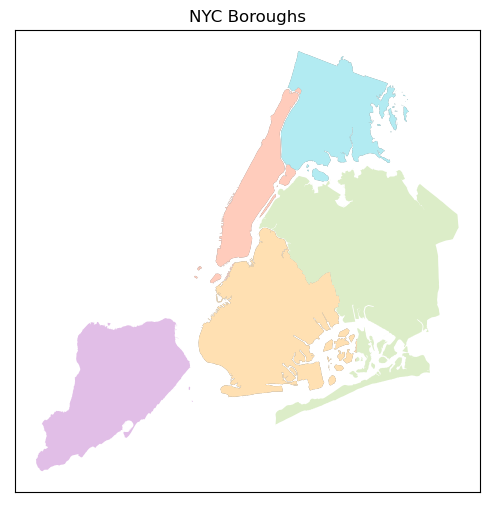

In [206]:
manhattan = nyc_boroughs[nyc_boroughs['borough'] == 'Manhattan']
brooklyn = nyc_boroughs[nyc_boroughs['borough'] == 'Brooklyn']
bronx = nyc_boroughs[nyc_boroughs['borough'] == 'Bronx']
queens = nyc_boroughs[nyc_boroughs['borough'] == 'Queens']
staten_island = nyc_boroughs[nyc_boroughs['borough'] == 'Staten Island']

manhattan_polygon = unary_union(manhattan.geometry)
brooklyn_polygon = unary_union(brooklyn.geometry)
bronx_polygon = unary_union(bronx.geometry)
queens_polygon = unary_union(queens.geometry)
staten_island_polygon = unary_union(staten_island.geometry)

fig, ax = plt.subplots(figsize = (6,6))
nyc_boroughs_mbb.plot(ax = ax, color = 'grey')
manhattan.plot(ax = ax, color = '#FFCCBC')
brooklyn.plot(ax = ax, color = '#FFE0B2')
bronx.plot(ax = ax, color = '#B2EBF2')
queens.plot(ax = ax, color = '#DCEDC8')
staten_island.plot(ax = ax, color = '#E1BEE7')
ax.set_title('NYC Boroughs')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Check if points are inside the polygon of the boroughs of interest and add a column to the trip dataframe to indicate the borough of the pickup and dropoff point

Now we can try to check if points are inside the polygon.

In [30]:
def inside_polygon(x, y):
    point = Point(x, y)
    if point.within(manhattan_polygon):
        return 'Manhattan'
    elif point.within(brooklyn_polygon):
        return 'Brooklyn'
    elif point.within(bronx_polygon):
        return 'Bronx'
    elif point.within(queens_polygon):
        return 'Queens'
    elif point.within(staten_island_polygon):
        return 'Staten Island'
    else:
        return 'Other'

inside_polygon_udf = udf(inside_polygon)

Looking at the questions below we need to have pickup_hour column, so we define it in datafarme trip3 so that after we don't have to compute it everytime we need it.

In [31]:
trip3 = trip2.withColumn('pickup_borough', inside_polygon_udf(col('pickup_longitude'), col('pickup_latitude'))) \
    .withColumn('dropoff_borough', inside_polygon_udf(col('dropoff_longitude'), col('dropoff_latitude'))) \
    .withColumn('pickup_hour', hour(col('pickup_datetime')))
trip3

medallion,hack_license,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_borough,dropoff_borough,pickup_hour
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 09:24:17,CMT,1,N,2013-01-01 09:33:15,1,537,2.7,-73.98407,40.721382,-73.959076,40.716599,CSH,10.5,0.0,0.5,0.0,0.0,11.0,Manhattan,Brooklyn,9
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 09:46:11,CMT,1,N,2013-01-01 09:57:32,1,681,2.7,-73.980301,40.722206,-73.992561,40.748272,CSH,11.0,0.0,0.5,0.0,0.0,11.5,Manhattan,Manhattan,9
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 10:17:38,CMT,1,N,2013-01-01 10:26:25,1,526,1.1,-73.982407,40.742542,-73.99382,40.749969,CSH,7.5,0.0,0.5,0.0,0.0,8.0,Manhattan,Manhattan,10
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 12:27:45,CMT,1,N,2013-01-01 12:30:49,1,184,0.8,-73.970665,40.749886,-73.967255,40.760506,CSH,5.0,0.0,0.5,0.0,0.0,5.5,Manhattan,Manhattan,12
00005007A9F30E289...,43468C5D35F828693...,2013-01-01 12:40:56,CMT,1,N,2013-01-01 12:48:17,1,441,1.1,-73.970558,40.785912,-73.971672,40.797298,CSH,7.0,0.0,0.5,0.0,0.0,7.5,Manhattan,Manhattan,12
00005007A9F30E289...,A9AE329EA1138052D...,2013-01-01 01:07:33,CMT,1,N,2013-01-01 01:19:52,2,738,3.4,-73.962669,40.775368,-73.956116,40.804432,CSH,13.0,0.5,0.5,0.0,0.0,14.0,Manhattan,Manhattan,1
00005007A9F30E289...,A9AE329EA1138052D...,2013-01-01 02:31:09,CMT,1,N,2013-01-01 02:42:14,4,665,2.6,-73.984711,40.769283,-73.953056,40.780083,CRD,11.0,0.5,0.5,2.4,0.0,14.4,Manhattan,Manhattan,2
00005007A9F30E289...,A9AE329EA1138052D...,2013-01-01 03:27:23,CMT,1,Y,2013-01-01 03:45:10,2,1066,5.4,-73.983292,40.761707,-74.016266,40.705795,CSH,19.5,0.5,0.5,0.0,0.0,20.5,Manhattan,Manhattan,3
00005007A9F30E289...,C72A773829ED990AF...,2013-01-01 17:49:49,CMT,1,N,2013-01-01 18:02:21,1,752,4.8,-73.953827,40.778835,-73.929901,40.831913,CSH,15.5,0.0,0.5,0.0,0.0,16.0,Manhattan,Bronx,17
00005007A9F30E289...,C72A773829ED990AF...,2013-01-01 19:58:15,CMT,1,N,2013-01-01 20:01:46,3,210,0.7,-73.99868,40.760933,-74.003738,40.751949,CSH,5.0,0.0,0.5,0.0,0.0,5.5,Manhattan,Manhattan,19


Here I decided to save the dataframe trip3 in a csv file, so that I don't have to compute it everytime I need it. This fastens the computation of the queries below.

In [32]:
trip3.write.csv('trip3.csv', header = True, mode = 'overwrite')

In [33]:
trip3_csv = session.read.option('inferSchema', True).option('header', True).csv('trip3.csv')

Now that the boroughs are defined, we need to count the trips.
- Manhattan → Manhattan
- Manhattan → Brooklyn
- Manhattan → Bronx
- Bronx → Bronx
- Bronx → Manhattan
- Bronx → Brooklyn
- Brooklyn → Brooklyn
- Brooklyn → Manhattan
- Brooklyn → Bronx

In [34]:
trip3_csv.createOrReplaceTempView('trip3_csv')

In [35]:
trip4 = session.sql('''
    SELECT pickup_borough, dropoff_borough, COUNT(*) AS count
    FROM trip3_csv
    WHERE pickup_borough IN ('Manhattan', 'Brooklyn', 'Bronx') AND dropoff_borough IN ('Manhattan', 'Brooklyn', 'Bronx')
    GROUP BY pickup_borough, dropoff_borough
    ORDER BY count DESC
''')
trip4

pickup_borough,dropoff_borough,count
Manhattan,Manhattan,319706
Manhattan,Brooklyn,14396
Brooklyn,Brooklyn,10454
Brooklyn,Manhattan,6408
Manhattan,Bronx,2779
Bronx,Bronx,487
Bronx,Manhattan,284
Brooklyn,Bronx,57
Bronx,Brooklyn,6


### Exercise 3
Imagine you are a taxi driver and one day you can work only two hours. Assume the data is representative of a typical working day. Which hours of the day - retrieved from `pickup_datetime` - would you choose to work based on the fare and tip amount?

As the exercise asks about one day the taxi driver can work only two hours, we can work with the data of the 2013-01-01, so the data in trip3.
First we need to create a new column that contains the hour of the day and another new column that contains the sum of fare_amount and tip_amount. Then we can drop some columns that we don't need for this analysis.

In [36]:
trip5 = trip3_csv.withColumn('fare_plus_tip_amount', col('fare_amount') + col('tip_amount')) \
    .drop('dropoff_datetime', 'medallion', 'hack_license', 'vendor_id', 'rate_code',
           'store_and_fwd_flag', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 
           'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'surcharge', 'mta_tax', 'total_amount')
trip5

pickup_datetime,fare_amount,tip_amount,tolls_amount,pickup_borough,dropoff_borough,pickup_hour,fare_plus_tip_amount
2013-01-01 07:46:02,3.5,0.0,0.0,Manhattan,Manhattan,7,3.5
2013-01-01 07:50:53,8.5,0.0,0.0,Manhattan,Manhattan,7,8.5
2013-01-01 14:44:00,14.5,1.0,0.0,Manhattan,Manhattan,14,15.5
2013-01-01 15:13:35,14.5,0.0,0.0,Manhattan,Manhattan,15,14.5
2013-01-01 00:29:39,10.0,0.0,0.0,Manhattan,Manhattan,0,10.0
2013-01-01 03:49:07,12.0,0.0,0.0,Manhattan,Manhattan,3,12.0
2013-01-01 19:19:22,4.5,0.0,0.0,Manhattan,Manhattan,19,4.5
2013-01-01 21:58:09,5.0,0.0,0.0,Manhattan,Manhattan,21,5.0
2013-01-01 17:14:00,4.0,0.0,0.0,Manhattan,Manhattan,17,4.0
2013-01-01 18:12:00,8.0,0.0,0.0,Manhattan,Manhattan,18,8.0


In [37]:
trip5.createOrReplaceTempView('trip5')

In [207]:
trip6 = session.sql('''
    SELECT pickup_hour, AVG(fare_plus_tip_amount) AS avg_fare_plus_tip_amount
    FROM trip5 
    GROUP BY pickup_hour
    ORDER BY avg_fare_plus_tip_amount DESC
    LIMIT 2
''')
trip6

pickup_hour,avg_fare_plus_tip_amount
7,17.126826658956197
6,17.04241059104028


As for the query we just made, we can see that the best 2 consecutive hours to work are 6am and 7am (so from 6 am till 8 am excluded), because they have the highest average.

This is due to the fact that from around 6am to around 8am people go to work and there's a higher demand of means if transport (including taxis).

### Exercise 4
Provide a graphical representation to compare the average fare amount for trips _within_ and _across_ all the districts. You may want to have a look at: https://docs.bokeh.org/en/latest/docs/user_guide/topics/categorical.html#heatmaps.

In order to plot the graph, we first need to select the columns pickup_borough, dropoff_borough, and make the average of fare_amount, within and across all districts.

In [39]:
trip7 = session.sql('''
    SELECT pickup_borough, dropoff_borough, AVG(fare_amount) AS avg_fare_amount
    FROM trip3_csv
    GROUP BY pickup_borough, dropoff_borough
    ORDER BY avg_fare_amount DESC
''')
trip7

pickup_borough,dropoff_borough,avg_fare_amount
Queens,Staten Island,72.43478260869566
Manhattan,Staten Island,53.80681818181818
Queens,Other,53.56472636815921
Manhattan,Other,49.817050534499515
Brooklyn,Bronx,46.31578947368421
Queens,Bronx,40.88188073394495
Bronx,Brooklyn,39.75
Staten Island,Manhattan,36.875
Queens,Brooklyn,35.698449976514794
Brooklyn,Staten Island,34.5


In [40]:
trip7_df = trip7.toPandas()
trip7_df.set_index('pickup_borough', inplace = True)

In [208]:
trip7_df_pivot = trip7_df.pivot(columns = 'dropoff_borough', values = 'avg_fare_amount').fillna(0)
trip7_df_pivot

dropoff_borough,Bronx,Brooklyn,Manhattan,Other,Queens,Staten Island
pickup_borough,,,,,,
Bronx,11.089528,39.750000,17.968310,29.613636,30.323529,0.000000
Brooklyn,46.315789,11.107069,19.068953,34.343750,25.099854,34.500000
Manhattan,26.943145,22.154661,9.485069,49.817051,29.315018,53.806818
Other,26.192308,29.634146,15.173629,18.004373,26.533333,5.500000
Queens,40.881881,35.698450,34.123361,53.564726,15.807753,72.434783
Staten Island,0.000000,20.000000,36.875000,2.500000,0.000000,25.776923


In [42]:
pickup = list(trip7_df_pivot.index)
dropoff = list(trip7_df_pivot.columns)

In [43]:
trip7df = pd.DataFrame(trip7_df_pivot.stack(), columns=['avg_fare_amount']).reset_index()
trip7df

,pickup_borough,dropoff_borough,avg_fare_amount
0,Bronx,Bronx,11.089528
1,Bronx,Brooklyn,39.750000
2,Bronx,Manhattan,17.968310
3,Bronx,Other,29.613636
4,Bronx,Queens,30.323529
5,Brooklyn,Bronx,46.315789
6,Brooklyn,Brooklyn,11.107069
7,Brooklyn,Manhattan,19.068953
8,Brooklyn,Other,34.343750
9,Brooklyn,Queens,25.099854


Let's plot the graph using bokeh.

In [211]:
palette = ["#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41"]

color_mapper = LinearColorMapper(palette = palette, low = trip7df.avg_fare_amount.min(), high = trip7df.avg_fare_amount.max())
color_bar = ColorBar(color_mapper = color_mapper, label_standoff = 8, width = 20, height = 380)

TOOLS = 'hover, save, pan, box_zoom, reset, wheel_zoom'

heatmap = figure(title = f'Average Fare Amount by Pickup and Dropoff Boroughs',
           x_range = pickup,
           y_range = dropoff,
           frame_width = 400, 
           frame_height = 400,
           tools = TOOLS, 
           toolbar_location = 'right',
           tooltips=[('Pickup Borough', '@pickup_borough'), ('Dropoff Borough', '@dropoff_borough'), ('Avg Fare Amount', '@avg_fare_amount')])
           
heatmap.grid.grid_line_color = None
heatmap.axis.axis_line_color = None
heatmap.axis.major_tick_line_color = None
heatmap.axis.major_label_text_font_size = '7px'
heatmap.axis.major_label_standoff = 0
heatmap.xaxis.major_label_orientation = pi / 3

heatmap.rect(x = 'pickup_borough', y = 'dropoff_borough', width = 1, height = 1, source = trip7df,
           fill_color = {'field': 'avg_fare_amount', 'transform': color_mapper},
           line_color = None)

heatmap.add_layout(color_bar, 'right')

show(heatmap)

### Exercise 5
Find the average amount of tolls per hour for trips within the following districts: Manhattan, Bronx, Brooklyn, Queens. Show a graphical representation of the data and report if there is any trend or peak during the day. Overall which district has the largest amount of tolls?

In [45]:
trip8 = session.sql('''
    SELECT pickup_borough, dropoff_borough, pickup_hour, AVG(tolls_amount) AS avg_tolls_amount
    FROM trip3_csv
    WHERE pickup_borough IN ('Manhattan', 'Brooklyn', 'Bronx', 'Queens') AND dropoff_borough IN ('Manhattan', 'Brooklyn', 'Bronx', 'Queens')
    GROUP BY pickup_hour, pickup_borough, dropoff_borough
    ORDER BY avg_tolls_amount DESC
''')
trip8

pickup_borough,dropoff_borough,pickup_hour,avg_tolls_amount
Queens,Bronx,17,4.8
Queens,Bronx,12,4.8
Bronx,Queens,12,4.8
Brooklyn,Bronx,11,4.8
Bronx,Brooklyn,17,4.8
Bronx,Queens,2,4.8
Bronx,Queens,3,4.8
Bronx,Queens,0,4.8
Bronx,Queens,7,4.8
Bronx,Queens,15,4.8


In [46]:
trip8_df = trip8.toPandas()
trip8_df

,pickup_borough,dropoff_borough,pickup_hour,avg_tolls_amount
0,Queens,Bronx,17,4.8
1,Queens,Bronx,12,4.8
2,Bronx,Queens,12,4.8
3,Brooklyn,Bronx,11,4.8
4,Bronx,Brooklyn,17,4.8
...,...,...,...,...
334,Bronx,Manhattan,18,0.0
335,Bronx,Brooklyn,12,0.0
336,Brooklyn,Bronx,23,0.0
337,Bronx,Manhattan,22,0.0


In [47]:
queens_data = trip8_df[trip8_df['pickup_borough'] == 'Queens']
bronx_data = trip8_df[trip8_df['pickup_borough'] == 'Bronx']
brooklyn_data = trip8_df[trip8_df['pickup_borough'] == 'Brooklyn']
manhattan_data = trip8_df[trip8_df['pickup_borough'] == 'Manhattan']

In [48]:
TOOLS2 = 'hover, save, pan, box_zoom, reset, wheel_zoom'

p1 = figure(title = f'Average Tolls Amount by Pickup Hour for Queens',
              x_axis_label = 'Pickup Hour',
              y_axis_label = 'Average Tolls Amount',
              x_range = (0,23),
              y_range = (0, 5),
              frame_width = 500,
              frame_height = 300,
              tools = TOOLS2,
              toolbar_location = 'right')

p1.vbar(x = queens_data['pickup_hour'], top = queens_data['avg_tolls_amount'], width = 0.9, color = '#009B72')

p2 = figure(title = f'Average Tolls Amount by Pickup Hour for Bronx',
              x_axis_label = 'Pickup Hour',
              y_axis_label = 'Average Tolls Amount',
              x_range = (0,23),
              y_range = (0, 5),
              frame_width = 500,
              frame_height = 300,
              tools = TOOLS2,
              toolbar_location = 'right')

p2.vbar(x = bronx_data['pickup_hour'], top = bronx_data['avg_tolls_amount'], width = 0.9, color = '#F25F5C')

p3 = figure(title = f'Average Tolls Amount by Pickup Hour for Brooklyn',
              x_axis_label = 'Pickup Hour',
                y_axis_label = 'Average Tolls Amount',
                x_range = (0,23),
                y_range = (0, 5),
                frame_width = 500,
                frame_height = 300,
                tools = TOOLS2,
                toolbar_location = 'right')

p3.vbar(x = brooklyn_data['pickup_hour'], top = brooklyn_data['avg_tolls_amount'], width = 0.9, color = '#009DDC')

p4 = figure(title = f'Average Tolls Amount by Pickup Hour for Manhattan',
              x_axis_label = 'Pickup Hour',
                y_axis_label = 'Average Tolls Amount',
                x_range = (0,23),
                y_range = (0, 5),
                frame_width = 500,
                frame_height = 300,
                tools = TOOLS2,
                toolbar_location = 'right')

p4.vbar(x = manhattan_data['pickup_hour'], top = manhattan_data['avg_tolls_amount'], width = 0.9, color = '#50514F')

grid = gridplot([[p1, p2], [p3, p4]], width = 250, height = 250)

show(grid)

As we can see from the graphs, the districts with the highest tolls is the district of Queens. 
- Tolls in the district of Queens (bar plot top left) are always higher than 3, except for 1am, 2am and 3am.
- Tolls in the district of Bronx (bar plot top right) are oddly distributed, we can see that tolls are practically at maximum from midnight to 3am and at 7am, midday, 3pm and 5pm.
- Tolls in the district of Brooklyn (bar plot bottom left) are always higher than 1 from midnight till 7am, then there is a peak at toll amount of 5 at 11am. 
- Tolls in the district of Manhattan (bar plot bottom right) are always lower than 4, we can also notice that the tolls amount is equal to or lower than 1 in the morning from midnight to 4am and at night from 8pm to midnight. The plot about Manhattan seems like a Normal Distribution and reflects working hours in which people commute.

We can identify a trend in the tolls during the day. For example, at 11am are always equal to or higher than 3.

### Exercise 6
Create a dataframe that for each district shows the shortest and longest `trip_distance` starting and ending in the same district. What is the length of the longest and shortest trips in Manhattan?

In [213]:
trip9 = session.sql('''
    SELECT pickup_borough, dropoff_borough, MIN(trip_distance) AS min_trip_distance, MAX(trip_distance) AS max_trip_distance
    FROM trip3_csv
    WHERE pickup_borough == dropoff_borough AND pickup_borough == 'Manhattan'
    GROUP BY pickup_borough, dropoff_borough
''')
trip9

pickup_borough,dropoff_borough,min_trip_distance,max_trip_distance
Manhattan,Manhattan,0.0,100.0


The longest trip within Manhattan has distance 100.0, while the shortest trip within Manhattan has distance 0.0.

### Exercise 7
Consider only the trips _within_ districts. What are the first and second-most expensive
trips - based on `total_amount` - in every district?

In [212]:
trip10 = trip3_csv.select('pickup_borough', 'dropoff_borough', 'total_amount') \
    .where(trip3_csv['pickup_borough'] == trip3_csv['dropoff_borough']) \
    .orderBy(trip3_csv['total_amount'].desc())

most_exp_d = trip10.groupby('pickup_borough', 'dropoff_borough').agg(F.collect_list('total_amount').alias('total_amount')) \
    .withColumn('total_amount', F.sort_array('total_amount', asc = False)) \
    .withColumn('total_amount', F.slice('total_amount', 1, 2))
most_exp_d

pickup_borough,dropoff_borough,total_amount
Manhattan,Manhattan,"[500.0, 475.0]"
Brooklyn,Brooklyn,"[180.25, 130.25]"
Queens,Queens,"[138.0, 116.0]"
Bronx,Bronx,"[84.0, 80.0]"
Other,Other,"[321.05, 317.0]"
Staten Island,Staten Island,"[91.25, 89.6]"


### Exercise 8
Create a dataframe where each row represents a driver, and there is one column per district.
For each driver-district, the dataframe provides the maximum number of consecutive trips
for the given driver, within the given district. 

For example, if for driver A we have (sorted by time):
- Trip 1: Bronx → Bronx
- Trip 2: Bronx → Bronx
- Trip 3: Bronx → Manhattan
- Trip 4: Manhattan → Bronx.
    
The maximum number of consecutive trips for Bronx is 2.

In [54]:
trip11 = trip3_csv.select('hack_license', 'pickup_datetime', 'dropoff_datetime', 'pickup_borough', 'dropoff_borough') \
    .orderBy('pickup_datetime')
trip11

hack_license,pickup_datetime,dropoff_datetime,pickup_borough,dropoff_borough
F4B5F923554A0BB82...,2013-01-01 00:00:00,2013-01-01 00:09:00,Manhattan,Manhattan
252392FA3463A93EC...,2013-01-01 00:00:00,2013-01-01 00:11:00,Manhattan,Manhattan
E7869308480393458...,2013-01-01 00:00:00,2013-01-01 00:14:00,Manhattan,Queens
A743BF59156638867...,2013-01-01 00:00:00,2013-01-01 00:13:00,Manhattan,Manhattan
B9C38E251CF991EF5...,2013-01-01 00:00:00,2013-01-01 00:19:00,Manhattan,Manhattan
452B322CA3BB3132F...,2013-01-01 00:00:00,2013-01-01 00:03:00,Manhattan,Manhattan
BB899DFEA9CC964B5...,2013-01-01 00:00:00,2013-01-01 00:04:00,Manhattan,Manhattan
562847F5581EEC46B...,2013-01-01 00:00:00,2013-01-01 00:15:29,Manhattan,Brooklyn
FECE89B16DF0601CC...,2013-01-01 00:00:00,2013-01-01 00:05:00,Manhattan,Manhattan
632F6951F36191B8B...,2013-01-01 00:00:00,2013-01-01 00:41:00,Manhattan,Other


In [192]:
window = Window.orderBy('pickup_time').partitionBy('hack_license')

sum = 0
def consecutive_trips(same_borough_col):
    global sum
    if same_borough_col == 1:
        sum += 1
        return sum
    else:
        sum = 0
        return sum


consecutive_trips_udf = F.udf(consecutive_trips, returnType=IntegerType())
session.udf.register('consecutive_trips_udf', consecutive_trips_udf)

trip11a = trip11.withColumn('pickup_time', F.date_format('pickup_datetime', 'HH:mm:ss')) \
    .withColumn('dropoff_time', F.date_format('dropoff_datetime', 'HH:mm:ss')) \
    .withColumn('next_pickup_borough', F.lead('pickup_borough').over(window)) \
    .withColumn('next_dropoff_borough', F.lead('dropoff_borough').over(window)) \
    .withColumn('current_borough', F.when(F.col('pickup_borough') == F.col('dropoff_borough'), F.col('pickup_borough'))) \
    .withColumn('next_borough', F.when(F.col('next_pickup_borough') == F.col('next_dropoff_borough'), F.col('next_pickup_borough'))) \
    .withColumn('same_borough', when(col('current_borough') == col('next_borough'), 1).otherwise(0)) \
    .withColumn('consecutive_trips', consecutive_trips_udf(col('same_borough'))) \
    .drop('next_pickup_borough', 'next_dropoff_borough', 'pickup_borough', 'dropoff_borough', 'pickup_datetime', 'dropoff_datetime')
trip11a

23/06/01 16:30:28 WARN SimpleFunctionRegistry: The function consecutive_trips_udf replaced a previously registered function.


hack_license,pickup_time,dropoff_time,current_borough,next_borough,same_borough,consecutive_trips
005DC767BC7CA7827...,11:45:50,11:49:53,Manhattan,Manhattan,1,1
005DC767BC7CA7827...,11:51:07,11:55:28,Manhattan,Manhattan,1,2
005DC767BC7CA7827...,11:59:12,12:13:29,Manhattan,Manhattan,1,3
005DC767BC7CA7827...,12:14:47,12:19:17,Manhattan,Manhattan,1,4
005DC767BC7CA7827...,12:21:12,12:34:58,Manhattan,Manhattan,1,5
005DC767BC7CA7827...,12:38:55,12:45:19,Manhattan,Manhattan,1,6
005DC767BC7CA7827...,12:49:41,12:53:11,Manhattan,Manhattan,1,7
005DC767BC7CA7827...,12:55:27,13:02:41,Manhattan,Manhattan,1,8
005DC767BC7CA7827...,13:04:44,13:10:29,Manhattan,Manhattan,1,9
005DC767BC7CA7827...,13:16:26,13:17:06,Manhattan,Manhattan,1,10


In [189]:
trip11_pivot = trip11a.groupby('hack_license').pivot('current_borough').agg(F.max('consecutive_trips')) \
    .fillna(0).drop('null')
trip11_pivot

hack_license,Bronx,Brooklyn,Manhattan,Other,Queens,Staten Island
01606C9E10D8D0B19...,0,0,19,0,0,0
02548BECEDACA82F0...,0,1,5,0,0,0
02856AFC22881ABCA...,0,0,15,0,0,0
03A2D28F831C5C3E5...,0,0,16,0,0,0
069B5562096AF7684...,0,0,4,0,0,0
0ABC9AB316BE37A29...,0,0,5,0,0,0
0FBF11956EE14B253...,0,0,22,0,0,0
130328475AD7427AF...,0,0,5,0,0,0
138B0A7B7D3B898E4...,0,0,10,0,0,0
1480A09D886B1A2CD...,0,0,1,0,0,0
